In [17]:
import random
from PIL import Image, ImageFilter
import numpy as np
import time
import glob
import torch
import os
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split as tts
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import yaml
import matplotlib.pyplot as plt

### Functions

In [14]:
class CPP:
    cutpaste_augmentations = {
        'jitter_offset': 0.1,
        'patch':{
            'area_ratio': (0.02, 0.15),
            'aspect_ratio': ((0.3, 1),(1, 3.3))
        },
        'scar':{
            'width': (2,16),
            'thiccness': (10,25)
        }
    }
    offset = cutpaste_augmentations['jitter_offset']
    jitter_transforms = transforms.ColorJitter(
                            brightness = offset,
                            contrast = offset,
                            saturation = offset,
                            hue = offset)
    summary = yaml.dump(cutpaste_augmentations, default_flow_style=False)


class GenerativeDataset(Dataset):
    def __init__(
            self, 
            task,
            images_filenames,
            imsize=(256,256),
            transform=None) -> None:

        super().__init__()
        self.images_filenames = images_filenames
        self.area_ratio = CPP.cutpaste_augmentations['patch']['area_ratio']
        self.aspect_ratio = CPP.cutpaste_augmentations['patch']['aspect_ratio']
        self.scar_width = CPP.cutpaste_augmentations['scar']['width']
        self.scar_thiccness = CPP.cutpaste_augmentations['scar']['thiccness']
        
        self.imsize = imsize
        self.task=task
        self.transform = transform
        
        self.labels = self.generate_labels()
    
    def generate_labels(self):
        length = self.images_filenames.shape[0]
        if self.task == '3-way':
            return np.array(np.random.uniform(0,3, length), dtype=int)
        if self.task == 'binary':
            return np.array(np.random.uniform(0,2, length), dtype=int)
        else:
            return np.empty(0)

    def __getitem__(self, index):
        x = self.images_filenames[index]
        y = self.labels[index]

        if self.task == '3-way':
            x = self.generate_cutpaste_3way(x, y)
        if self.task == 'binary':
            x = self.generate_cutpaste_binary(x, y)
        
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return self.images_filenames.shape[0]
    
    def generate_cutpaste_3way(self, x, y):
        x = Image.open(x).resize(self.imsize).convert('RGB')
        x = generate_rotation(x)
        if y == 0:
            return x
        if y == 1:
            patch, coords = generate_patch(x, self.area_ratio, self.aspect_ratio)
            patch = apply_jittering(patch, CPP.jitter_transforms)
            x = paste_patch(x, patch, coords)
            return x
        if y == 2:
            patch, coords = generate_scar(x.size, self.scar_width, self.scar_thiccness)
            x = paste_patch(x, patch, coords, patch)
            return x

    def generate_cutpaste_binary(self, x, y):
        x = Image.open(x).resize(self.imsize).convert('RGB')
        x = generate_rotation(x)
        if y == 0:
            return x
        else:
            if random.randint(0,1) == 1:
                patch, coords = generate_patch(x, self.area_ratio, self.aspect_ratio)
                patch = apply_jittering(patch, CPP.jitter_transforms)
                x = paste_patch(x, patch, coords)
                return x
            else:
                patch, coords = generate_scar(x.size, self.scar_width, self.scar_thiccness)
                x = paste_patch(x, patch, coords, patch)
                return x


class GenerativeDatamodule(pl.LightningDataModule):
    def __init__(
            self, 
            root_dir:str, #qualcosa come ../dataset/bottle/
            imsize=(256,256),
            batch_size:int=64,  
            train_val_split:float=0.2,
            classification_task='binary',
            seed:int=0,
            min_dataset_length=1000,
            duplication=False):
        
        super().__init__()
        self.save_hyperparameters()
        self.root_dir_train = root_dir+'/train/good/'
        self.root_dir_test = root_dir+'/test/good/'
        self.imsize = imsize
        self.batch_size = batch_size
        self.train_val_split = train_val_split
        self.classification_task = classification_task
        
        self.seed = seed
        self.min_dataset_length = min_dataset_length
        self.duplication = duplication

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
        
        self.prepare_filenames()

    def prepare_filenames(self):
        images_filenames = get_image_filenames(self.root_dir_train)

        train_images_filenames, val_images_filenames = tts(
            images_filenames, 
            test_size=self.train_val_split, 
            random_state=self.seed)
        test_images_filenames = get_image_filenames(self.root_dir_test)
        
        if self.duplication:
            self.train_images_filenames = duplicate_filenames(
                train_images_filenames,
                self.min_dataset_length)
            self.val_images_filenames = duplicate_filenames(
                val_images_filenames,
                self.min_dataset_length)
            
            self.test_images_filenames = duplicate_filenames(
                    test_images_filenames,
                    self.min_dataset_length)
        else:
            self.train_images_filenames = train_images_filenames
            self.val_images_filenames = val_images_filenames
            self.test_images_filenames = test_images_filenames
    
    def prepare_data(self) -> None:
        pass
    
    def setup(self, stage:str=None) -> None:
        if stage == 'fit' or stage is None:
            self.val_dataset = GenerativeDataset(
                self.classification_task,
                self.val_images_filenames,
                imsize=self.imsize,
                transform=self.transform)
            
        if stage == 'test' or stage is None:
            self.test_dataset = GenerativeDataset(
                self.classification_task,
                self.test_images_filenames,
                imsize=self.imsize,
                transform=self.transform)

    def train_dataloader(self):
        self.train_dataset = GenerativeDataset(
                self.classification_task,
                self.train_images_filenames,
                imsize=self.imsize,
                transform=self.transform)
        
        return DataLoader(
            self.train_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            drop_last=True,
            num_workers=8)

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            drop_last=True,
            num_workers=8)
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            num_workers=8)


def get_image_filenames(main_path:str):
    return np.array(sorted([f for f in glob.glob(main_path+'*.png', recursive = True)]))


def duplicate_filenames(filenames, baseline=2000):
    dummy_copy = np.array(filenames, copy=True)
    while dummy_copy.shape[0] < baseline:
        dummy_copy = np.concatenate([dummy_copy, filenames], dtype=str)
    return dummy_copy


def generate_rotations(image):
    r90 = image.rotate(90)
    r180 = image.rotate(180)
    r270 = image.rotate(270)
    return image, r90, r180, r270


def generate_rotation(image):
    rotation = random.choice([0, 90, 180, 270])
    return image.rotate(rotation)


def generate_patch(
        image, 
        area_ratio=(0.02, 0.15), 
        aspect_ratio=((0.3, 1),(1, 3.3))):

    #print('generate_patch', area_ratio)
    img_area = image.size[0] * image.size[1]
    patch_area = random.uniform(area_ratio[0], area_ratio[1]) * img_area
    patch_aspect = random.choice([random.uniform(*aspect_ratio[0]), random.uniform(*aspect_ratio[1])])
    patch_w  = int(np.sqrt(patch_area*patch_aspect))
    patch_h = int(np.sqrt(patch_area/patch_aspect))
    org_w, org_h = image.size

    patch_left, patch_top = random.randint(0, org_w - patch_w), random.randint(0, org_h - patch_h)
    patch_right, patch_bottom = patch_left + patch_w, patch_top + patch_h
    paste_left, paste_top = random.randint(0, org_w - patch_w), random.randint(0, org_h - patch_h)

    return image.crop((patch_left, patch_top, patch_right, patch_bottom)), (paste_left, paste_top)


def paste_patch(image, patch, coords, mask=None):
    aug_image = image.copy()
    aug_image.paste(patch, (coords[0], coords[1]), mask=mask)
    return aug_image


def apply_jittering(img, augmentations):
    return augmentations(img)

# not used
def apply_gaussian_blur(img):
    return img.filter(ImageFilter.BoxBlur(random.randint(0, 3)))


def random_color():
    return random.randint(10,240)


def generate_scar(imsize:tuple, w_range=(2,16), h_range=(10,25)):
    img_w, img_h = imsize

    #dimensioni sezione
    scar_w = random.randint(w_range[0], w_range[1])
    scar_h = random.randint(h_range[0], h_range[1])

    r = random_color()
    g = random_color()
    b = random_color()

    color = (r,g,b)

    scar = Image.new('RGBA', (scar_w, scar_h), color=color)
    angle = random.randint(-45, 45)
    scar = scar.rotate(angle, expand=True)

    #posizione casuale della sezione
    left, top = random.randint(0, img_w - scar_w), random.randint(0, img_h - scar_h)
    return scar, (left, top)


## Check dataset integrity

Check if the images are corrected generated and with the correct label

In [15]:
subject = 'bottle'
dataset_dir = '/home/ubuntu/TesiAnomalyDetection/dataset/'
results_dir = '/home/ubuntu/TesiAnomalyDetection/outputs/computations/'
imsize=(256,256)
batch_size = 64
train_val_split = 0.2
seed = 0
datamodule = GenerativeDatamodule(
    root_dir=dataset_dir+subject+'/',
    imsize=imsize,
    batch_size=batch_size,
    train_val_split=train_val_split,
    classification_task='3-way',
    seed=seed,
    min_dataset_length=500,
    duplication=True
)
datamodule.setup('test')
x,y = next(iter(datamodule.test_dataloader())) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0, 1, 1, 2, 2])


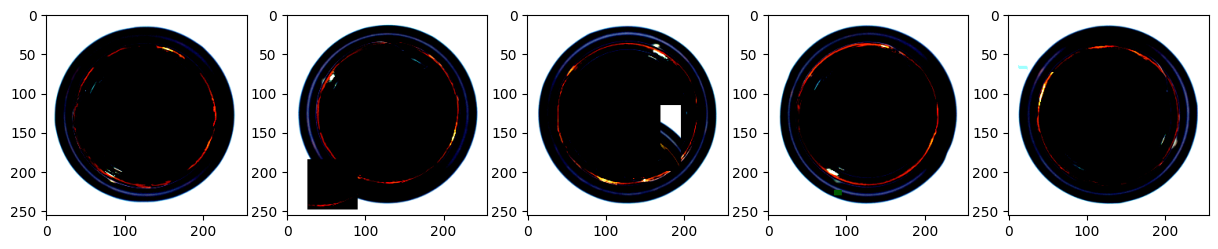

In [29]:
n = 5
images = torch.permute(x[:n], (0,3,2,1))
print(y[:n])
fig, axs = plt.subplots(1, n, figsize=(15,15))
for i in range(n):
    axs[i].imshow(np.array(images[i], np.float32))